# GPU Ocean Tutorial - Deterministic Trajectory Forecast

We use the tutorial to show the deterministic drifter plotting utils

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

GPU Ocean-modules:

In [2]:
from gpuocean.SWEsimulators import CDKLM16
from gpuocean.utils import Common, IPythonMagic, NetCDFInitialization, Observation
from gpuocean.drifters import GPUDrifterCollection
from gpuocean.dataassimilation import DataAssimilationUtils as dautils

In [3]:
%cuda_context_handler gpu_ctx

## Selecting area and loading initial- and boundary conditions

As initial and boundary conditions to the simulation, we use data from the Norkyst800 model:

In [4]:
source_url = 'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'
#locally:
#source_url = '/home/johanna/gpu-ocean/gpu_ocean/papers/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'

In [5]:
casename = 'lofoten'
data_args = NetCDFInitialization.getInitialConditionsNorKystCases(source_url,casename, download_data=False)

With <code> NetCDFInitialization.getCaseLocation </code> we get more information about the chosen domain:

In [6]:
NetCDFInitialization.getCaseLocation('lofoten')

{'name': 'lofoten', 'x0': 1400, 'x1': 1900, 'y0': 450, 'y1': 750}

In [7]:
domain = [1400, 1900, 450, 750] # [x0,x1,y0,y1]

## Creating simulator and forecast

In [8]:
sim_args = {
    "gpu_ctx": gpu_ctx,
    "dt": 0.0,
     }

sim = CDKLM16.CDKLM16(**sim_args, **NetCDFInitialization.removeMetadata(data_args))

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [9]:
observation_args = {
                'nx': sim.nx, 'ny': sim.ny,
                'domain_size_x': sim.nx*sim.dx,
                'domain_size_y': sim.ny*sim.dy,
                'land_mask': sim.getLandMask()
               }

forecast = Observation.Observation(**observation_args)

## Creating drifters

In [10]:
num_drifters = 3
drifters = GPUDrifterCollection.GPUDrifterCollection(gpu_ctx, num_drifters, 
                                                 boundaryConditions = sim.boundary_conditions,
                                                 domain_size_x = forecast.domain_size_x,
                                                 domain_size_y = forecast.domain_size_y,
                                                 gpu_stream = sim.gpu_stream)


In [11]:
init_positions = np.array([[196790, 148550],  #[[x1, y1],
                           [217930, 80860],  # [x2, y2],
                           [104890, 146440]]) # [x3, y3]]
drifters.setDrifterPositions(init_positions)

The positions are given in meters from the edge of the domain, which corresponds to 800 times the number of cells into the domain. 

## Running the simulation

In [12]:
start_drifters_hours = 5
total_hours = 24
dt = 5*60 # Stepsize: 5min (in seconds)
timesteps_per_hour = int(60*60 / dt)

#Create progress bar
progress = Common.ProgressPrinter(5)
pp = display(progress.getPrintString(0), display_id=True)

#Run simulation
for hour in range(total_hours):
    
    if hour == start_drifters_hours:                  #Attach drifters 
        sim.attachDrifters(drifters)
        forecast.add_observation_from_sim(sim)
    
    for n in range(timesteps_per_hour):    
        t = sim.step(dt)                              #make one step forward in time
        if hour >= start_drifters_hours:               #Add positions to observation only if drifters have been attached
            forecast.add_observation_from_sim(sim) 
    
    #Update progress bar
    pp.update(progress.getPrintString(hour/(total_hours-1)))

'0% [##############################] 100%. Total: 30s, elapsed: 30s, remaining: 0s'

## Accessing and plotting the results

The trajectory of a drifter is accessed with the function <code> Observation.get_drifter_path </code>. We add the paths from our 3 drifters to a list:

In [13]:
start_time = 5 * 3600 #5 hours (when drifters were attached)
end_time = 24 * 3600 #24 hours (end of forecast)

drifter_paths = [None]*3
for i in range(3):
    drifter_id = i
    drifter_paths[i] = forecast.get_drifter_path(drifter_id, start_time, end_time, in_km = False)

## New Drifter Plotting

In [14]:
from importlib import reload
from gpuocean.utils import DrifterPlotHelper
reload(DrifterPlotHelper)

<module 'gpuocean.utils.DrifterPlotHelper' from '/home/florianb/havvarsel/gpuocean/src/gpuocean/utils/DrifterPlotHelper.py'>

/home/florianb/havvarsel/gpuocean/src/gpuocean/utils/DrifterPlotHelper.py:161: RuntimeWarning: invalid value encountered in sqrt
  velo = np.sqrt(u**2 + v**2)


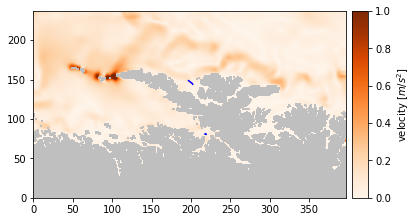

In [15]:
ax = DrifterPlotHelper.background_from_sim(sim)

DrifterPlotHelper.add_drifter_on_background(ax, forecast)
DrifterPlotHelper.add_drifter_on_background(ax, forecast, drifter_id=1)


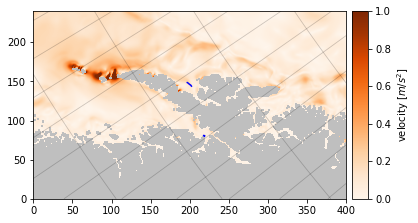

In [16]:
ax = DrifterPlotHelper.background_from_netcdf(source_url, domain=domain, lonlat_diff=1)

DrifterPlotHelper.add_drifter_on_background(ax, forecast)
DrifterPlotHelper.add_drifter_on_background(ax, forecast, drifter_id=1)